# Dimensionality Reduction with PCA

## Task 1

This notebook deals with the understanding and usage of the ___Principal Component Analysis (PCA)___ on different datasets. PCA is a model-based way to reduce the amount of "uninformative" or redundant information, meaning that it tries to reduce the amount of individual features while trying to lose as little information as possible.
The newly obtained features from the PCA can then be used instead of the (higher-dimensional) original feature vector.

__"The key idea here is to replace redundant features with a few new features that adequately summarize information contained in the original feature space."__

To gain some understanding we will first take a look at how to "manually" extract the principal components to then use tools provided by scikit-learn to achieve the same goal. Most of the information and content in _Task 1_ is taken from LINK and packed into this notebook to get a better overview as well as have all the information in one place.

### Overview
The main goal of __PCA__ is to create new features that maximize the variance in the data. This can be seen in the figure below, where the values for x1 and x2 are plotted on the x- and y-axis and the principal components vectors (eigenvectors of the covariance matrix) point into a different direction than the axes. Each principal component/eigenvector is perpendicular to each other, and the amount of contained information/variance decreases for every new component.

<center>
<img src="img/05_01.png" width="400" height="400"/>
</center>

### Implementation
#### Manual and Step-by-step
First we are going to load, split and standardize an example dataset to perform the PCA on. 

In [20]:
import pandas as pd

df = pd.read_csv("../../data/05/wine.data")

df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


Now we use sklearn train_test_split() to split our dataset into training and test data (80/20).

In [21]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:,1:].values, df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)

Standardize data with sklearn:

In [22]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

We can extract the principal components by performing an eigendecomposition on the covariance matrix of our training data.

In [23]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)

print('\nEigenvalues \n%s' % eigenvals)


Eigenvalues 
[0.1147366  0.17167047 0.21033081 0.21746413 0.28679355 0.35492175
 0.52733586 0.67438038 0.87446062 0.98966494 1.52535442 2.47190241
 4.6738412 ]


Then we use these eigenvalues to calculate the amount of variance each of these components explains. Here we first calculate the total amount of variance by summing up all eigenvalues to then normalize each individual value by this sum. Additionally we track the cumulative explained variance.

In [24]:
var_total = sum(eigenvals)
var_explained = [(i /var_total) for i in sorted(eigenvals, reverse=True)]
cum_var_explained = np.cumsum(var_explained)

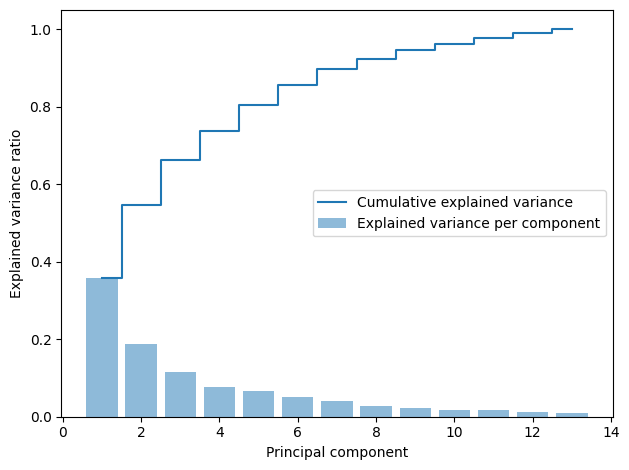

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.bar(range(1, len(eigenvals)+1), var_explained, alpha=0.5, align='center',
        label='Explained variance per component')
plt.step(range(1, len(eigenvals)+1), cum_var_explained, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##### Feature transformation
In order to use these newly aquired principal components as features we need to perform a base transformation where we use the PCs as new axes in our coordinate system. This will lead to unrecognizable data as the values of the original features are transformed. 
Below we first combine eigenvalues and eigenvectors into a list of tuples (eigen_pairs).

In [26]:
# Make a list of (eigenvalue, eigenvector) tuples
# eigenvectors stored as columns of a matrix -> [:, i]
eigen_pairs = [(np.abs(eigenvals[i]), eigenvecs[:, i])
               for i in range(len(eigenvals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

eigen_pairs[0]

(4.673841202208121,
 array([-0.14872732,  0.22904722, -0.03338967,  0.21916637, -0.14002402,
        -0.40182571, -0.42322967,  0.30114483, -0.30899698,  0.05586878,
        -0.30882218, -0.36929032, -0.30828504]))

This list of eigen_pairs has ofc. 13 elements, one for each principal component. Each of the elements of this list are tuples, and each tuple contains the eigenvalue as well as the eigenvector coordinates for each dimension. As PCA is often used for dimensionality reduction lets assume we want only to use the first two principal components (the ones with the highest explained variance as we want to capture as much underlying information as possible).

__Exercise:__ How much of the original variance was captured by the first two principal components? How much additional explained variance is provided by the third PC?

In [27]:
# code here
print("Variance explained by 1. PC: {}  2. PC: {}  cum.: {}".format(var_explained[0],var_explained[1],cum_var_explained[1]))
print("Variance explained by 1. PC: {}  2. PC: {}  3. PC: {}  cum.: {}".format(var_explained[0],var_explained[1],var_explained[2],cum_var_explained[2]))

Variance explained by 1. PC: 0.356976414789491  2. PC: 0.18879778387988896  cum.: 0.5457741986693799
Variance explained by 1. PC: 0.356976414789491  2. PC: 0.18879778387988896  3. PC: 0.11650279229142411  cum.: 0.6622769909608041


As mentioned above we only want to use the first two PCs of the 13 that were derived. These two components capture more than half of the explained variance of the underlying original dataset and could thus be a suitable choice to perform dimension reduction while simultaneously minimizing the loss of information. We use _numpy.hstack_ to create a new matrix with two columns that contains all coordinate values for the first two eigenvectors. 

In [28]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.14872732 -0.48711401]
 [ 0.22904722 -0.2065399 ]
 [-0.03338967 -0.30144962]
 [ 0.21916637  0.04352763]
 [-0.14002402 -0.29877422]
 [-0.40182571 -0.04888575]
 [-0.42322967  0.02480015]
 [ 0.30114483 -0.07650036]
 [-0.30899698 -0.01919307]
 [ 0.05586878 -0.54529619]
 [-0.30882218  0.23973982]
 [-0.36929032  0.22377049]
 [-0.30828504 -0.35200392]]


__Exercise:__ Use the code from above to create a matrix _w2_ from the coordinates of the four most informative components.

In [29]:
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis],
               eigen_pairs[2][1][:, np.newaxis],
               eigen_pairs[3][1][:, np.newaxis]))
print('Matrix W:\n', w2)

Matrix W:
 [[-0.14872732 -0.48711401 -0.19562273 -0.03261083]
 [ 0.22904722 -0.2065399   0.12330588 -0.51627054]
 [-0.03338967 -0.30144962  0.62402556  0.1814255 ]
 [ 0.21916637  0.04352763  0.63233774  0.02579285]
 [-0.14002402 -0.29877422  0.15063657  0.45511106]
 [-0.40182571 -0.04888575  0.13749629 -0.21443828]
 [-0.42322967  0.02480015  0.14270911 -0.17550212]
 [ 0.30114483 -0.07650036  0.13184287 -0.00123888]
 [-0.30899698 -0.01919307  0.13274445 -0.44633166]
 [ 0.05586878 -0.54529619 -0.10011143 -0.11227926]
 [-0.30882218  0.23973982  0.03907181  0.37970139]
 [-0.36929032  0.22377049  0.1700445  -0.16040995]
 [-0.30828504 -0.35200392 -0.14084858  0.18216839]]


Now that we have our matrix _w_ we can transform our data by taking the dot product of the original data and the PCA-column vectors, projecting the original data onto the PCA axes.

In [30]:
print("X_train_std[0]: {}\n".format(X_train_std[0]))
print("X_train_std[0].dot(w): {}".format(X_train_std[0].dot(w)))

X_train_pca = X_train_std.dot(w)

X_train_std[0]: [-1.68663219 -0.25482431  0.28379926  0.5761055  -1.10568379 -0.55692029
 -0.33305239  0.94484033 -0.42658144 -0.96055888  0.24341489  0.19874555
 -0.21394802]

X_train_std[0].dot(w): [1.10890446 1.80089046]


When plotting the results we can see that the first two PCs already achieve quite good clustering, even though they 

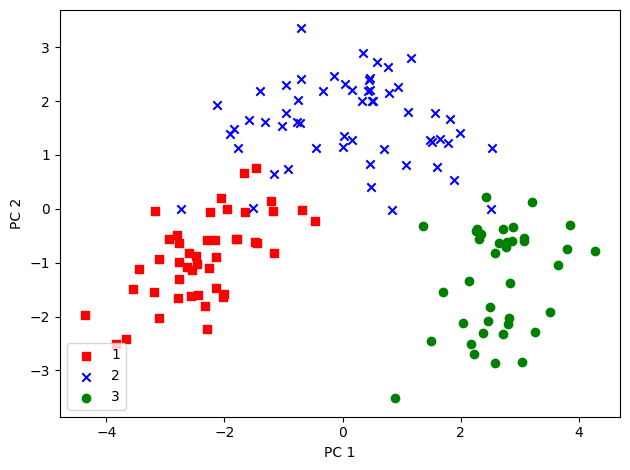

In [31]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

__Exercise:__ Now take only the best and the worst PCs and use them as basis for the feature transformation. How does the resulting scatter plot differ from the one shown above? What's the reason behind this?

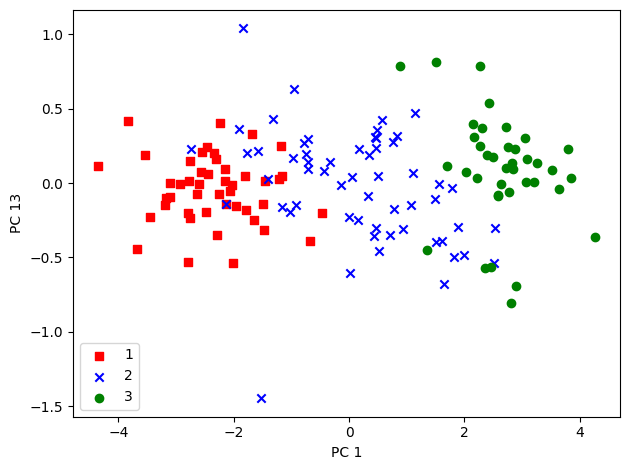

In [32]:
# implementation here
w3 = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[-1][1][:, np.newaxis]))

X_train_pca_last = X_train_std.dot(w3)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca_last[y_train == l, 0], 
                X_train_pca_last[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 13')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### PCA with scikit-learn
Of course you do not always have to perform these tasks by hand as there is already a scikit-learn implementation for the PCA. This makes it more comfortable to use and takes care of the underlying math. To perform the same operations as above we just have to do the following when utilizing sklearn:

In [33]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.35697641, 0.18879778, 0.11650279, 0.07558816, 0.06678914,
       0.0515075 , 0.04027661, 0.02710804, 0.02190458, 0.01660937,
       0.01606455, 0.01311177, 0.0087633 ])

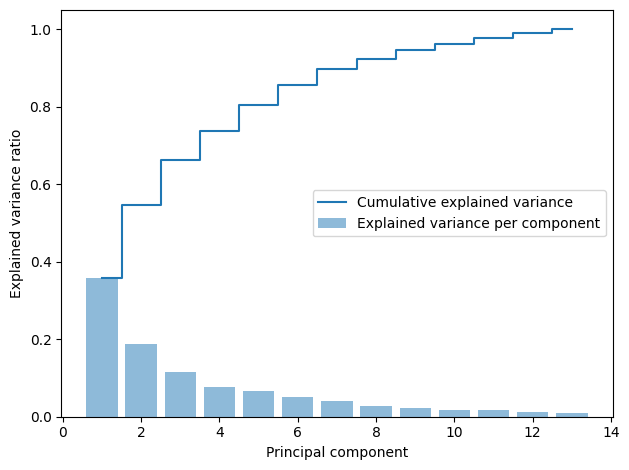

In [34]:

plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center',
        label='Explained variance per component')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Task 2


In this task you will take a closer look at the _Iris_ dataset ("IRIS.csv", __[download from here](https://github.com/DataScienceLabFHSWF/machine-learning-book/tree/main/data/pca)__) which lists different attributes of the Iris flower, taken from various samples. The goal here is to predict the correct species by applying and comparing different machine learning algorithms of your choice.  
Perform PCA on the data and take a look at the _explained variance_ in order to get the best trade-off between dimensionality-reduction and information loss. Train and test every model you consider on the PCA-transformed and the original data to see the impact of the aforementioned loss. 

In [55]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/05/IRIS.csv")

df.tail()

df2 = df.drop("species", axis=1)

df2

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### Visualization
Plot the distribution of the different features in the dataset. What kind of scaling would you choose for the different attributes?

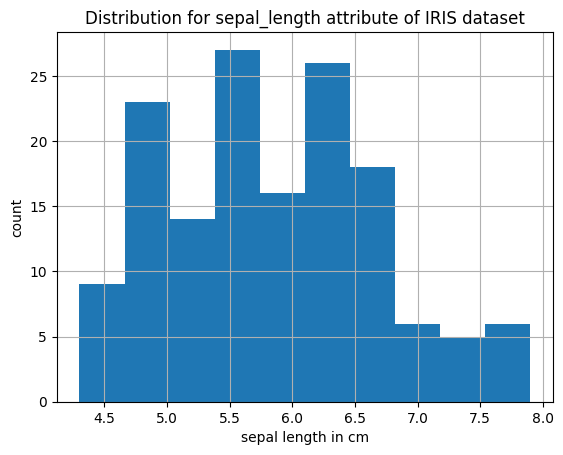

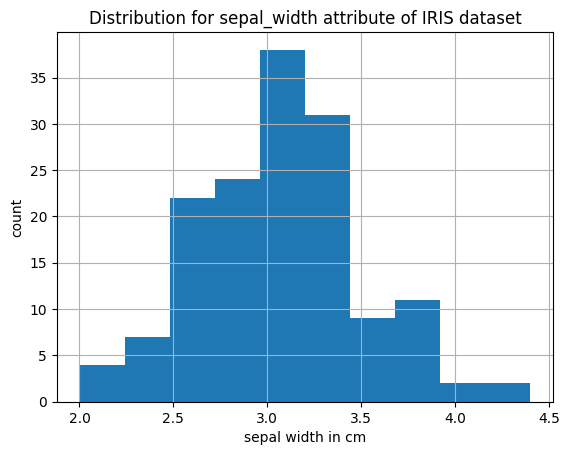

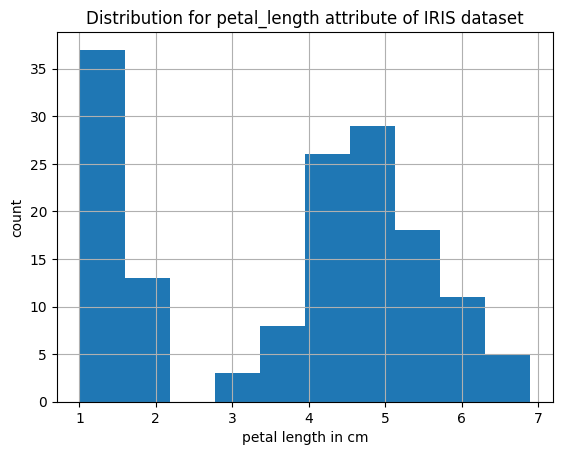

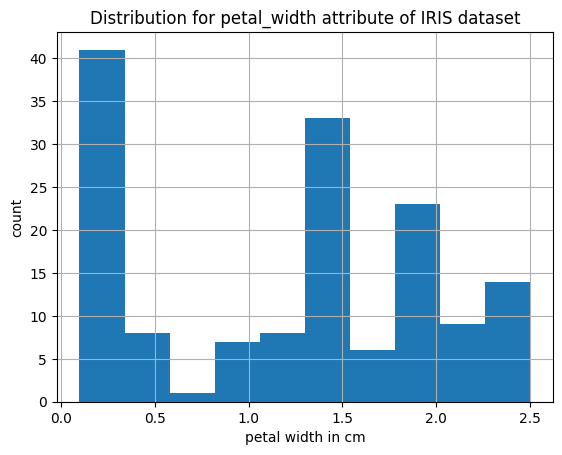

In [36]:
df["sepal_length"].hist(bins=10)
plt.title("Distribution for sepal_length attribute of IRIS dataset")
plt.xlabel("sepal length in cm")
plt.ylabel("count")
plt.show()

df["sepal_width"].hist(bins=10)
plt.title("Distribution for sepal_width attribute of IRIS dataset")
plt.xlabel("sepal width in cm")
plt.ylabel("count")
plt.show()

df["petal_length"].hist(bins=10)
plt.title("Distribution for petal_length attribute of IRIS dataset")
plt.xlabel("petal length in cm")
plt.ylabel("count")
plt.show()

df["petal_width"].hist(bins=10)
plt.title("Distribution for petal_width attribute of IRIS dataset")
plt.xlabel("petal width in cm")
plt.ylabel("count")
plt.show()

Use the _seaborn_ package to plot a heatmap of the correlation matrix of the dataframe (df.corr()). Which attributes are highly correlated, which feature sticks out?

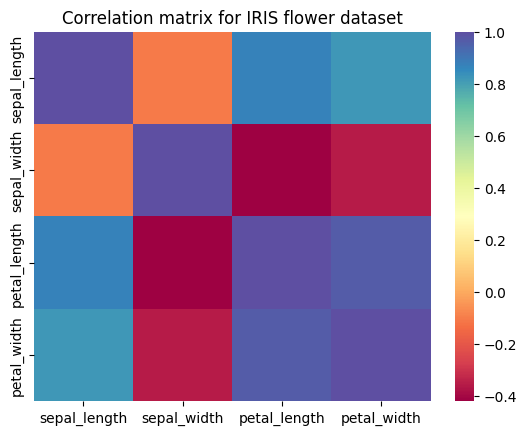

In [56]:
sns.heatmap(df2.corr(),cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Correlation matrix for IRIS flower dataset")
plt.show()

### Preprocess
Preprocess the data here (label encoding, scaling)

In [57]:
le = preprocessing.LabelEncoder()
mm_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()

df["species"] = le.fit_transform(df["species"])
df["sepal_length"] = std_scaler.fit_transform(df[["sepal_length"]])
df["sepal_width"] = std_scaler.fit_transform(df[["sepal_width"]])
df["petal_length"] = mm_scaler.fit_transform(df[["petal_length"]])
df["petal_width"] = mm_scaler.fit_transform(df[["petal_width"]])
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.900681,1.032057,0.067797,0.041667,0
1,-1.143017,-0.124958,0.067797,0.041667,0
2,-1.385353,0.337848,0.050847,0.041667,0
3,-1.506521,0.106445,0.084746,0.041667,0
4,-1.021849,1.263460,0.067797,0.041667,0
...,...,...,...,...,...
145,1.038005,-0.124958,0.711864,0.916667,2
146,0.553333,-1.281972,0.677966,0.750000,2
147,0.795669,-0.124958,0.711864,0.791667,2
148,0.432165,0.800654,0.745763,0.916667,2


### PCA
### Apply and create dataframe
Split the dataframe into two separate dataframes (feature data and target data (X,y)). Apply PCA to the feature data, build a new dataframe from the transformed components and store it as _X\_pca_.

In [59]:
from sklearn.decomposition import PCA

X = df.drop("species",axis=1)
y = df["species"]

pca = PCA()

X_pca = pca.fit_transform(X)
# X_train_pca = pca.fit_transform(X_train_std)


# plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center',
#         label='Explained variance per component')
# plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid',
#          label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()
pd.DataFrame(X_pca).head()

,0,1,2,3
0,-1.455969,0.279529,-0.106310,-0.007277
1,-0.989664,-0.804970,-0.163329,-0.031353
2,-1.435418,-0.564167,-0.036554,-0.010195
3,-1.388417,-0.820071,-0.007764,0.019015
4,-1.676748,0.400462,-0.038877,0.010427


Plot the heatmap of the PCA-transformed dataframe and compare it to the map from above. How can you explain the differences?

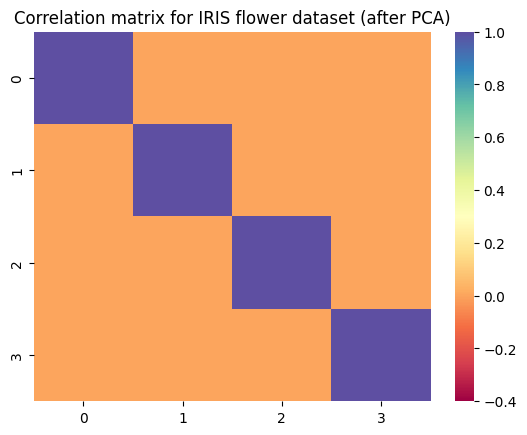

In [64]:
sns.heatmap(pd.DataFrame(X_pca).corr(),cmap=sns.color_palette("Spectral", as_cmap=True), vmin=-0.4,vmax=1)
plt.title("Correlation matrix for IRIS flower dataset (after PCA)")
plt.show()

Take a look at the explained variance of the principal components and display display it in a plot. How many components would you choose to get the best trade-off between dimensionality-reduction and information loss? How much of the variance in the entire dataset do they represent?

explained variance (%): [57.15256413 41.31852252  1.43562122  0.09329213]
['PC1', 'PC2', 'PC3', 'PC4']


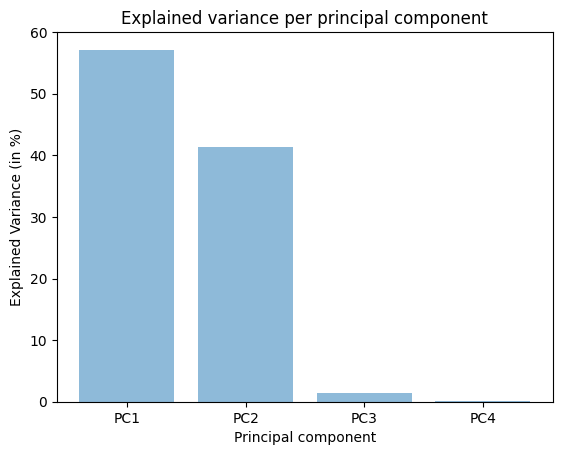

In [42]:
explained_var = pca.explained_variance_ratio_
print("explained variance (%): {}".format(np.array(explained_var)*100))

labels = ["PC{}".format(int(i)) for i in range(1,len(explained_var)+1)]

print(labels)
plt.bar(labels, explained_var*100, alpha=0.5, align='center', label='Explained variance per component')
plt.title("Explained variance per principal component")
plt.xlabel("Principal component")
plt.ylabel("Explained Variance (in %)")
plt.show()

Now create a dataframe out of your chosen components (_np.hstack()_).

In [43]:
# df_pca = pd.DataFrame(X_pca)

ft_pcs = np.hstack((X_pca[:,0][:, np.newaxis],
                    X_pca[:,1][:, np.newaxis]))
                    
X2 = pd.DataFrame(ft_pcs, columns=labels[:2])
X2 = pd.concat([X2,pd.DataFrame(y)],axis=1)
X2

### Alternative
# pca2 = PCA(2)
# X_pca2 = pca2.fit_transform(X)
# X2 = pd.DataFrame(X_pca22)
# X2 = pd.concat([X2,pd.DataFrame(y)],axis=1)


,PC1,PC2,species
0,-1.455969,0.279529,0
1,-0.989664,-0.804970,0
2,-1.435418,-0.564167,0
3,-1.388417,-0.820071,0
4,-1.676748,0.400462,0
...,...,...,...
145,1.022739,0.534360,2
146,1.257829,-0.701760,2
147,0.810079,0.387964,2
148,0.056928,0.951668,2


Create a scatter plot of the first two PCs

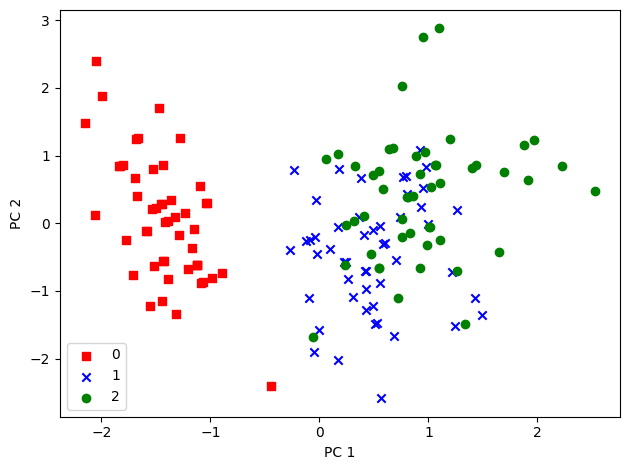

In [65]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X2[y == l]["PC1"], 
                X2[y == l]["PC2"],  
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Training
Split the datasets (original and PCA-transformed) into train and test data and use different algorithms of your choice to try and achieve the highest target score.
Use _train\_test\_splot from _sklearn.model_selection_ (random_state: 25, test_size: 0.25)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=25,test_size=0.25)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X2,y,random_state=25,test_size=0.25)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

algorithms = [LogisticRegression(),GaussianNB(),RandomForestClassifier(),KNeighborsClassifier(3)]
algorithm_names = ["LogisticRegression","GaussianNB","RandomForest","KNeighborsClassifier"]

models = []
scores = []

print("Without PCA:")
for i,algo in enumerate(algorithms):
    model = algo.fit(X_train,y_train)
    score = algo.score(X_test,y_test)
    models.append(model)
    scores.append(score)
    print(f"{algorithm_names[i]}: {score}")

print(f"\nWith PCA:")
for i,algo in enumerate(algorithms):
    model = algo.fit(X_pca_train,y_train)
    score = algo.score(X_pca_test,y_test)
    models.append(model)
    scores.append(score)
    print(f"{algorithm_names[i]}: {score}")


Without PCA:
LogisticRegression: 0.8947368421052632
GaussianNB: 0.9210526315789473
RandomForest: 0.9473684210526315
KNeighborsClassifier: 0.8421052631578947

With PCA:
LogisticRegression: 0.9736842105263158
GaussianNB: 1.0
RandomForest: 0.9736842105263158
KNeighborsClassifier: 0.9736842105263158


Plot the results. Which of the algorithms you chose performed best? Do the results surprise you in any way?

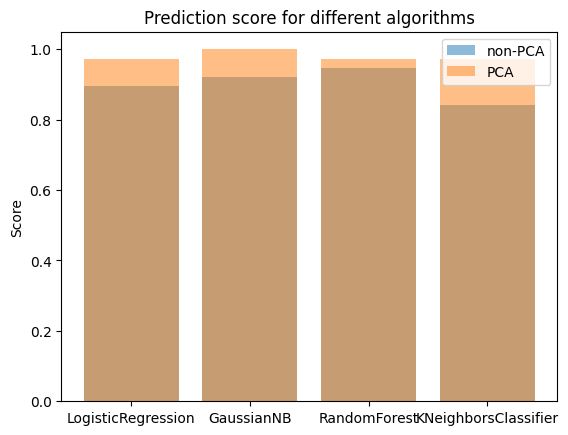

In [47]:
plt.bar(algorithm_names, scores[:4], alpha=0.5, align='center', label='non-PCA')
plt.bar(algorithm_names, scores[4:8], alpha=0.5, align='center', label='PCA')
plt.title("Prediction score for different algorithms")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Task 3
In this task we try to predict the anticipated final status of bank loans, given various attributes describing the loan taker. The _credit_ dataset for this task can be downloaded from __[here](https://github.com/DataScienceLabFHSWF/machine-learning-book/tree/main/data/pca)__.  
As always, load the data into a dataframe and get familiar with it (__[might be useful](https://www.investopedia.com/terms/c/chargeoff.asp)__). What kinds of categories do you see (numerical, categorical)? 

In [48]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv("credit.csv")

df.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'credit.csv'

Are there any features that correlate strongly with each other?

In [ ]:
sns.heatmap(df.corr(),cmap=sns.color_palette("Spectral", as_cmap=True))
plt.show()

### Dealing with missing data
You might have noticed that there are quite a few missing/na values in our dataset. Take a closer look at each of the attributes that has missing values and try to decide how to best deal with it (fill with constant value, drop entirely, ...).


In [ ]:
np.sum(df.isna())

In [ ]:
df["Credit Score"].describe()
df["Credit Score"].info()
df["Credit Score"] = df["Credit Score"].fillna(df["Credit Score"].median())
df["Credit Score"].info()

In [ ]:
df["Annual Income"] = df["Annual Income"].fillna(df["Annual Income"].median())
np.sum(df.isna())

In [ ]:
print(df.Bankruptcies.value_counts())
df.Bankruptcies.fillna(0.0,inplace=True)

np.sum(df.isna())

In [ ]:
df[df["Maximum Open Credit"].isna()]

In [ ]:
df = df.dropna(subset=["Maximum Open Credit","Years in current job","Tax Liens"])
np.sum(df.isna())

### Categorical variables
At this point your dataframe should have no attributes with missing values left. In the next step you should use One-Hot-Encoding or Label-Encoding to transform the categorical values into numerical/binary ones.  
What are the names of these features? Which technique(s) did you use?  

First encode the target column:

In [ ]:
label_enc = preprocessing.LabelEncoder()

print(df["Loan Status"].value_counts())
df["Loan Status"] = label_enc.fit_transform(df["Loan Status"])
print(df["Loan Status"].value_counts())

And now the other attributes:

In [ ]:
df["Years in current job"].value_counts()

In [ ]:
df_cleaned = df.dropna(subset=["Years in current job"]).drop(["Months since last delinquent"],axis=1)
np.sum(df_cleaned.isna())
len(df_cleaned.columns)
df_cleaned.info()
df_cleaned.describe()
len(df_cleaned)

In [ ]:
df_cleaned.dtypes
columns_purpose = np.unique(df_cleaned["Purpose"].values)
columns_ho = np.unique(df_cleaned["Home Ownership"].values)
columns_term = np.unique(df["Term"].values)
columns_yicj = np.unique(df["Years in current job"].values)

lb = preprocessing.LabelBinarizer()
le = preprocessing.LabelEncoder()

bin_purpose = lb.fit_transform(df.Purpose)
bin_home_owner = lb.fit_transform(df["Home Ownership"])
bin_term = le.fit_transform(df["Term"])
bin_years_in_current_job = lb.fit_transform(df["Years in current job"])

Now append these transformed matrizes to your cleaned dataframe (_pd.concat()_) to create the final version of the dataset.

In [ ]:
# dic = {"HO_0":f1[:,0],"HO_1":f1[:,1],"HO_2":f1[:,2],"HO_3":f1[:,3]}
# df_cleaned["HO_0"] = f1[:,0]
# df_cleaned.append(dic,ignore_index=True)
# df_cleaned.append(f1.tolist())
df_cleaned_new = pd.concat([df_cleaned, pd.DataFrame(bin_purpose, columns=columns_purpose).set_index(df_cleaned.index)], axis=1)
df_cleaned_new = pd.concat([df_cleaned_new, pd.DataFrame(bin_home_owner, columns=columns_ho).set_index(df_cleaned_new.index)], axis=1)
df_cleaned_new = pd.concat([df_cleaned_new, pd.DataFrame(bin_years_in_current_job, columns=columns_yicj).set_index(df_cleaned_new.index)], axis=1)
df_cleaned_new["Term"] = bin_term

# df_cleaned_new.drop(["Purpose","Home Ownership","Years in current job"],axis=1,inplace=True)
df_cleaned_new.drop(["Years of Credit History","Number of Credit Problems","Number of Open Accounts","Purpose","Home Ownership","Years in current job","Term","Credit Score","Loan Status","Customer ID","Loan ID","Annual Income","Monthly Debt"],axis=1,inplace=True)
df_cleaned_new

### PCA
Perform the PCA and plot the important metrics. How many components are needed to explain most of the variance?  


In [ ]:
X = df_cleaned_new.iloc[:,4:]
y = df_cleaned_new.iloc[:,3]


pca_model = PCA()
X_pca = pca_model.fit_transform(X)

plt.bar(range(1, len(pca_model.explained_variance_ratio_)+1), pca_model.explained_variance_ratio_, alpha=0.5, align='center',
        label='Explained variance per component')
# plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid',
#          label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Training
Use the cleaned and encoded dataframe for training and test data. Compare the results of PCA-transformed and the cleaned, untransformed dataset.

In [ ]:
len(df_cleaned[df_cleaned["Loan Status"]==0])

In [ ]:
pca_model1 = PCA(1)
pca_model2 = PCA(2)
X_pca1 = pca_model1.fit_transform(X)
X_pca2 = pca_model2.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.25) 

X_pca1_train, X_pca1_test, y_train, y_test = train_test_split(X_pca1,y,random_state=42,test_size=0.25) 
X_pca2_train, X_pca2_test, y_train, y_test = train_test_split(X_pca2,y,random_state=42,test_size=0.25) 

### Evaluation and results

Apply various machine learning algorithms to your training data and measure and plot the results. What do you notice?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

algorithms = [LogisticRegression(),RandomForestClassifier(),KNeighborsClassifier(3)]
datasets = [[X_train, X_test, y_train, y_test],[X_pca1_train, X_pca1_test, y_train, y_test],[X_pca2_train, X_pca2_test, y_train, y_test]]

models = []
scores = []

for i,ds in enumerate(datasets):
    print(f"Dataset {i}:")
    for algo in algorithms:
        model = algo.fit(ds[0],ds[2])
        score = algo.score(ds[1],ds[3])
        models.append(model)
        scores.append(score)
        print(f"{str(algo)}: {score}")
        
# print("Without PCA:")
# for i,algo in enumerate(algorithms):
#     model = algo.fit(X_train,y_train)
#     score = algo.score(X_test,y_test)
#     models.append(model)
#     scores.append(score)
#     print(f"{str(algo)}: {score}")

# print(f"\nWith PCA(1):")
# for i,algo in enumerate(algorithms):
#     model = algo.fit(X_pca1_train,y_train)
#     score = algo.score(X_pca1_test,y_test)
#     models.append(model)
#     scores.append(score)
#     print(f"{str(algo)}: {score}")

# print(f"\nWith PCA(2):")
# for i,algo in enumerate(algorithms):
#     model = algo.fit(X_pca2_train,y_train)
#     score = algo.score(X_pca2_test,y_test)
#     models.append(model)
#     scores.append(score)
#     print(f"{str(algo)}: {score}")

knn_testrange = range(1,20)
knn_scores = []

for i in knn_testrange:
    model = KNeighborsClassifier(i).fit(X_train,y_train)
    knn_scores.append(model.score(X_test,y_test))

In [ ]:
plt.plot(knn_testrange,knn_scores)
plt.show()

In [ ]:
algorithm_names = [str(el) for el in algorithms]

plt.bar(algorithm_names, scores[:3], alpha=0.5, align='center', label='non-PCA')
plt.bar(algorithm_names, scores[3:6], alpha=0.5, align='center', label='PCA(1)')
plt.bar(algorithm_names, scores[6:9], alpha=0.5, align='center', label='PCA(2)')
plt.title("Prediction score for different algorithms")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()